In [1]:
import modin.pandas as pd
import numpy as np
from scipy.sparse import hstack, csr_matrix
from textblob import TextBlob
import nltk
import re
import datetime
from time import time
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearnex import patch_sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVR
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from wordcloud import WordCloud, STOPWORDS 

%matplotlib inline

Read data files

In [2]:
train = pd.read_csv('C:/Users/Gaurav/Documents/Intel Hackathon/Sentiment/training_data.csv')
test = pd.read_csv('C:/Users/Gaurav/Documents/Intel Hackathon/Sentiment/test_data.csv')
submission = pd.read_csv('C:/Users/Gaurav/Documents/Intel Hackathon/Sentiment/sample.csv')
test_id = test['IDLink']

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init(runtime_env={'env_vars': {'__MODIN_AUTOIMPORT_PANDAS__': '1'}})

2023-05-28 15:20:07,714	INFO worker.py:1625 -- Started a local Ray instance.


Explore data

In [3]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,02-04-2002 12:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,20-09-2008 12:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,28-01-2012 12:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,01-03-2015 00:06,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,01-03-2015 00:11,-1,-1,-1,0.000000,0.141084


In [4]:
train.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 40508 entries, 0 to 40507
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  -----------------  --------------  -----  
 0   IDLink             40508 non-null  object
 1   Title              40508 non-null  object
 2   Headline           40508 non-null  object
 3   Source             40390 non-null  object
 4   Topic              40508 non-null  object
 5   PublishDate        40508 non-null  object
 6   Facebook           40508 non-null  int64
 7   GooglePlus         40508 non-null  int64
 8   LinkedIn           40508 non-null  int64
 9   SentimentTitle     40508 non-null  float64
 10  SentimentHeadline  40508 non-null  float64
dtypes: object(6), int64(3), float64(2)
memory usage: 3.4 MB


In [5]:
train.describe()

,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
count,40508.000000,40508.000000,40508.000000,40508.000000,40508.000000
mean,142.675225,5.016737,14.014269,-0.007364,-0.029286
std,745.148920,22.592353,73.032200,0.135795,0.142007
min,-1.000000,-1.000000,-1.000000,-0.838525,-0.755355
25%,0.000000,0.000000,0.000000,-0.079057,-0.116213
50%,6.000000,0.000000,0.000000,0.000000,-0.027277
75%,39.000000,2.000000,4.000000,0.062500,0.057474
max,40836.000000,1267.000000,3652.000000,0.962354,0.900000


Check for missing values

In [6]:
train.isnull().sum()

IDLink                 0
Title                  0
Headline               0
Source               118
Topic                  0
PublishDate            0
Facebook               0
GooglePlus             0
LinkedIn               0
SentimentTitle         0
SentimentHeadline      0
dtype: int64

In [7]:
test.isnull().sum()

IDLink          0
Title           0
Headline        0
Source         57
Topic           0
PublishDate     0
Facebook        0
GooglePlus      0
LinkedIn        0
dtype: int64

In [8]:
train['Source'].value_counts()[:5]

Bloomberg           725
Reuters             559
ABC News            457
Business Insider    442
New York Times      416
Name: Source, dtype: int64

In [9]:
train['Source'] = train['Source'].fillna('Bloomberg')
test['Source'] = test['Source'].fillna('Bloomberg')

Text columns processing and cleaning

In [10]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

def clean(text):
  text_token = word_tokenize(text)
  filtered_text = ' '.join([w.lower() for w in text_token if w.lower() not in stop and len(w) > 2])
  filtered_text = filtered_text.replace(r"[^a-zA-Z]+", '')
  text_only = re.sub(r'\b\d+\b', '', filtered_text)
  clean_text = text_only.replace(',', '').replace('.', '').replace(':', '')
  return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
train['Text_Title'] = train['Title'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Title'] = test['Title'] + ' ' + test['Source'] + ' ' + test['Topic']

train['Text_Headline'] = train['Headline'] + ' ' + train['Source'] + ' ' + train['Topic']
test['Text_Headline'] = test['Headline'] + ' ' + test['Source'] + ' ' + test['Topic']

In [12]:
train['Text_Title'][4]

'Tourism, govt spending buoys Thai economy in January The Nation - Thailand&#39;s English news economy'

In [13]:
train['Text_Title'] = [clean(x) for x in train['Text_Title']]
test['Text_Title'] = [clean(x) for x in test['Text_Title']]

train['Text_Headline'] = [clean(x) for x in train['Text_Headline']]
test['Text_Headline'] = [clean(x) for x in test['Text_Headline']]

In [14]:
train['Text_Title'][4]

'tourism govt spending buoys thai economy january nation thailand english news economy'

Feature extraction from text data

In [15]:
vectorizer = TfidfVectorizer(use_idf=True)

train_v_Title = vectorizer.fit_transform(train['Text_Title'])
test_v_Title = vectorizer.transform(test['Text_Title'])

vectorizer_ = TfidfVectorizer()

train_v_Headline = vectorizer_.fit_transform(train['Text_Headline'])
test_v_Headline = vectorizer_.transform(test['Text_Headline'])

SVD to reduce dimensions

Calculate sentiment of text data

In [16]:
train['polarity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_t'] = train['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_t'] = test['Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [17]:
train['polarity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
test['polarity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity)

train['subjectivity_h'] = train['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
test['subjectivity_h'] = test['Headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

Encode categorical columns

In [18]:
encoder = LabelEncoder()

train['Topic'] = encoder.fit_transform(train['Topic'])
test['Topic'] = encoder.transform(test['Topic'])

total = train['Source'].to_list() + test['Source'].to_list()
total = encoder.fit_transform(total)
train['Source'] = encoder.transform(train['Source'])
test['Source'] = encoder.transform(test['Source'])

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


Meta Features

In [19]:
# Get day-type(monday, tuesday) from datetime

train_weekday = []
test_weekday = []

for i in train['PublishDate']:
    train_weekday.append(datetime.datetime.strptime(i, "%d-%m-%Y %H:%M").strftime("%A"))
    
for i in test['PublishDate']:
    test_weekday.append(datetime.datetime.strptime(i, "%d-%m-%Y %H:%M").strftime("%A"))

train['weekday'] = train_weekday
test['weekday'] = test_weekday


# convert weekday to 0-6

train['weekday'] = train['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})
test['weekday'] = test['weekday'].map({'Monday': 0,
                                        'Tuesday': 1,
                                        'Wednesday': 2,
                                        'Thursday': 3,
                                        'Friday': 4,
                                        'Saturday': 5,
                                        'Sunday': 6})

In [20]:
# Hour from date

train["hour"] = train["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])
test["hour"] = test["PublishDate"].apply(lambda x: x.split()[1].split(':')[0])

Text(0, 0.5, 'SentimentTitle')

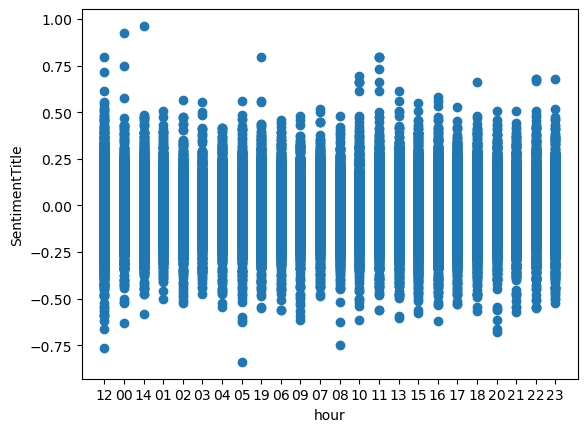

In [21]:
# hour distribution of SentimentTitle

plt.scatter(train['hour'], train['SentimentTitle'])
plt.xlabel('hour')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

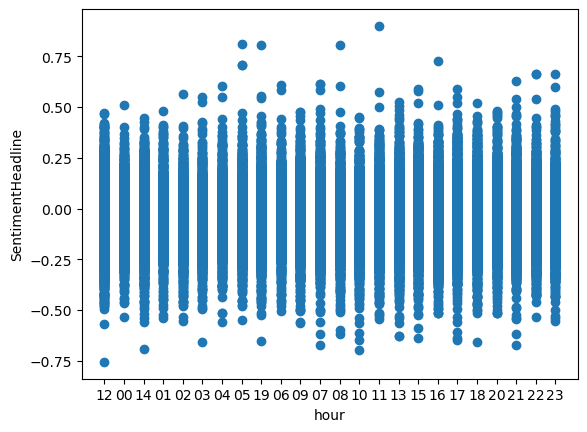

In [22]:
# hour distribution of SentimentHeadline

plt.scatter(train['hour'], train['SentimentHeadline'])
plt.xlabel('hour')
plt.ylabel('SentimentHeadline')

Text(0, 0.5, 'SentimentTitle')

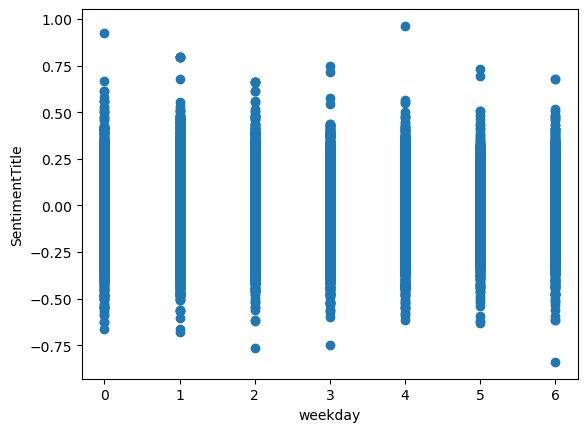

In [23]:
# weekday distribution of SentimentTitle

plt.scatter(train['weekday'], train['SentimentTitle'])
plt.xlabel('weekday')
plt.ylabel('SentimentTitle')

Text(0, 0.5, 'SentimentHeadline')

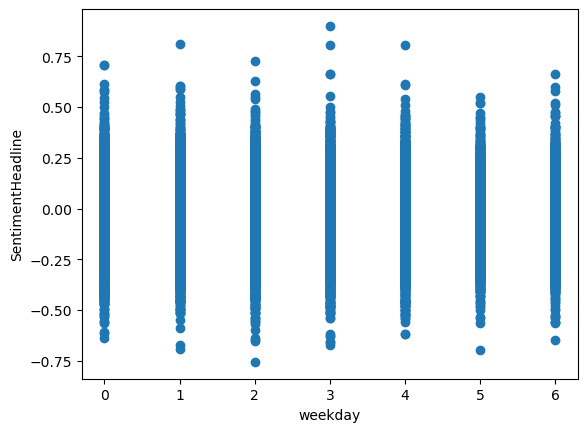

In [24]:
# weekday distribution of SentimentHeadline

plt.scatter(train['weekday'], train['SentimentHeadline'])
plt.xlabel('weekday')
plt.ylabel('SentimentHeadline')

In [25]:
# Number of words in the Title 
train["num_words_t"] = train["Text_Title"].apply(lambda x: len(str(x).split()))
test["num_words_t"] = test["Text_Title"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Title 
train["num_unique_words_t"] = train["Text_Title"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_t"] = test["Text_Title"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Title 
train["num_chars_t"] = train["Text_Title"].apply(lambda x: len(str(x)))
test["num_chars_t"] = test["Text_Title"].apply(lambda x: len(str(x)))

# Average length of the words in the Title 
train["mean_word_len_t"] = train["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_t"] = test["Text_Title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [26]:
# Number of words in the Headline 
train["num_words_h"] = train["Text_Headline"].apply(lambda x: len(str(x).split()))
test["num_words_h"] = test["Text_Headline"].apply(lambda x: len(str(x).split()))

# Number of unique words in the Headline 
train["num_unique_words_h"] = train["Text_Headline"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words_h"] = test["Text_Headline"].apply(lambda x: len(set(str(x).split())))

# Number of characters in the Headline 
train["num_chars_h"] = train["Text_Headline"].apply(lambda x: len(str(x)))
test["num_chars_h"] = test["Text_Headline"].apply(lambda x: len(str(x)))

# Average length of the words in the Headline 
train["mean_word_len_h"] = train["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len_h"] = test["Text_Headline"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Perform Standard Scaler operations for Machine learning

In [27]:
scaler = StandardScaler()

cols = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t',
        'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'hour', 'weekday']

for col in cols:
  train[col] = scaler.fit_transform(train[col].values.reshape(-1, 1))
  test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [28]:
cols_t = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_t', 'num_unique_words_t', 'num_chars_t', 'mean_word_len_t', 'polarity_t', 'subjectivity_t', 'hour', 'weekday']
train_X1 = train[cols_t]
test_X1 = test[cols_t]

cols_h = ['Source', 'Topic', 'Facebook', 'GooglePlus', 'LinkedIn', 'num_words_h', 'num_unique_words_h', 'num_chars_h', 'mean_word_len_h', 'polarity_h', 'subjectivity_h', 'hour', 'weekday']
train_X2 = train[cols_h]
test_X2 = test[cols_h]

In [29]:
train_X1.head()

,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_t,num_unique_words_t,num_chars_t,mean_word_len_t,polarity_t,subjectivity_t,hour,weekday
0,1.246801,0.851842,-0.192816,-0.266321,-0.205587,-0.254347,-0.300421,-0.567699,-0.612870,0.0,0.0,-0.065753,-0.786790
1,-1.324322,-1.099548,-0.192816,-0.266321,-0.205587,-1.661619,-1.712518,-1.624560,0.276170,0.0,0.0,-0.065753,1.339522
2,-1.324322,-1.099548,-0.192816,-0.266321,-0.205587,-1.192529,-1.241819,-1.030076,0.330601,0.0,0.0,-0.065753,1.339522
3,0.476858,-1.099548,-0.192816,-0.266321,-0.205587,-1.661619,-1.241819,-2.219044,-1.438408,0.0,0.0,-1.948880,1.871100
4,1.018954,-1.099548,-0.192816,-0.266321,-0.205587,1.152924,1.111676,1.017592,-0.295356,0.0,0.0,-1.948880,1.871100


In [30]:
train_X2.head()

,Source,Topic,Facebook,GooglePlus,LinkedIn,num_words_h,num_unique_words_h,num_chars_h,mean_word_len_h,polarity_h,subjectivity_h,hour,weekday
0,1.246801,0.851842,-0.192816,-0.266321,-0.205587,-0.282125,-0.523863,-0.487326,-1.059748,0.000000,0.000000,-0.065753,-0.786790
1,-1.324322,-1.099548,-0.192816,-0.266321,-0.205587,-0.282125,-0.228284,-0.313685,-0.174210,0.100000,0.200000,-0.065753,1.339522
2,-1.324322,-1.099548,-0.192816,-0.266321,-0.205587,-0.410103,-0.671653,-0.296321,0.622774,0.000000,0.041667,-0.065753,1.339522
3,0.476858,-1.099548,-0.192816,-0.266321,-0.205587,0.101809,0.067295,0.311423,0.848587,-0.166667,0.166667,-1.948880,1.871100
4,1.018954,-1.099548,-0.192816,-0.266321,-0.205587,0.229788,0.215084,0.398243,0.622774,0.133333,0.380556,-1.948880,1.871100


In [31]:
print(np.shape(train_X1))
print(np.shape(test_X1))

(40508, 13)
(15424, 13)


In [32]:
print(np.shape(train_X2))
print(np.shape(test_X2))

(40508, 13)
(15424, 13)


In [33]:
print(np.shape(train_v_Title))
print(np.shape(test_v_Title))

(40508, 21672)
(15424, 21672)


In [34]:
print(np.shape(train_v_Headline))
print(np.shape(test_v_Headline))

(40508, 33347)
(15424, 33347)


In [36]:
train_X_Title = hstack([train_v_Title, csr_matrix(train_X1.values)])
test_X_Title = hstack([test_v_Title, csr_matrix(test_X1.values)])
y1 = train['SentimentTitle']

train_X_Headline = hstack([train_v_Headline, csr_matrix(train_X2.values)])
test_X_Headline = hstack([test_v_Headline, csr_matrix(test_X2.values)])
y2 = train['SentimentHeadline']

In [37]:
np.shape(train_X_Title)

(40508, 21685)

Apply Machine Learning Models without intel extension Scikit-learn

In [45]:
# LinearSVR model for SentimentTitle
start_unopt = time()
X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2,dual=True,max_iter=10000)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)
finish_unopt = time()
f"Execution time without Intel(R) Extension for Scikit-learn: {(finish_unopt - start_unopt):.2f} s"

MAE: 0.9410565075370549


'Execution time without Intel(R) Extension for Scikit-learn: 86.65 s'

In [46]:
# LinearSVR model for SentimentHeadline
start_unopt = time()
X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.2,dual=True,max_iter=10000)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)
finish_unopt = time()
f"Execution time without Intel(R) Extension for Scikit-learn: {(finish_unopt - start_unopt):.2f} s"

MAE: 0.9274976777454984


'Execution time without Intel(R) Extension for Scikit-learn: 71.72 s'

In [47]:
print('MAE:', 1 - ((0.4 * mae1) + (0.6 * mae2)))

MAE: 0.932921209662121


Apply Machine Learning Models with intel extension Scikit-learn

In [48]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [49]:
start_opt = time()
X_train, X_test, y_train, y_test = train_test_split(train_X_Title, y1, test_size=0.20, random_state=42)

clf1 = LinearSVR(C=0.2,dual=True,max_iter=10000)
clf1.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
mae1 = mean_absolute_error(y_pred1, y_test)
print('MAE:', 1 - mae1)
finish_opt = time()
f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_opt - start_opt):.2f} s"

MAE: 0.9410569270267362


'Execution time with Intel(R) Extension for Scikit-learn: 77.84 s'

In [50]:
# LinearSVR model for SentimentHeadline
start_opt = time()
X_train, X_test, y_train, y_test = train_test_split(train_X_Headline, y2, test_size=0.20, random_state=42)

clf2 = LinearSVR(C=0.2,dual=True,max_iter=10000)
clf2.fit(X_train, y_train)

y_pred2 = clf2.predict(X_test)
mae2 = mean_absolute_error(y_pred2, y_test)
print('MAE:', 1 - mae2)
finish_opt = time()
f"Execution time with Intel(R) Extension for Scikit-learn: {(finish_opt - start_opt):.2f} s"

MAE: 0.9274986301697116


'Execution time with Intel(R) Extension for Scikit-learn: 68.97 s'

Make predictions for test dataset

In [51]:
title = clf1.predict(test_X_Title)
headline = clf2.predict(test_X_Headline)

Save results in csv

In [53]:
df = pd.DataFrame()
df['IDLink'] = test_id
df['SentimentTitle'] = title
df['SentimentHeadline'] = headline
df.to_csv('C:/Users/Gaurav/Documents/Intel Hackathon/Sentiment/sample_submit.csv', index=False)

(_deploy_ray_func pid=3964) 2023-05-28 15:40:03,867	ERROR import_thread.py:83 -- ImportThread: <_MultiThreadedRendezvous of RPC that terminated with:
(_deploy_ray_func pid=3964) 	status = StatusCode.UNKNOWN
(_deploy_ray_func pid=3964) 	details = "Stream removed"
(_deploy_ray_func pid=3964) 	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:64347 {created_time:"2023-05-28T10:10:03.865336834+00:00", grpc_status:2, grpc_message:"Stream removed"}"
(_deploy_ray_func pid=3964) >
